In [1]:
import os
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [2]:
# save_root_dir = "testing_contrastive_results"
# save_root_dir = "testing_contrastive_distinct_init_train_long_results"
# save_root_dir = "testing_contrastive_distinct_init_adapt_results"
# save_root_dir = "testing_contrastive_refactor_freezing_results"
# save_root_dir = "testing_contrastive_results_20epochs"
save_root_dir = "vanilla_init_big_mod_nocontrast_results"
# save_root_dir = "finding_hyper_for_mod_contrastive_large_results"
# save_root_dir = "vanilla_results"
dataset = "cifar100"
# dataset = "mnist"
# algo = "monolithic"
algo = "modular"
num_train = 256
# num_train = 64
# seed = 0
seed = 1
# use_contrastive = True
use_contrastive = False

In [3]:
job_name = f"{dataset}_{algo}_numtrain_{num_train}"
if use_contrastive:
    job_name += "_contrastive"
experiment = os.path.join(save_root_dir, job_name, dataset,algo, f"seed_{seed}")

In [4]:
config_path = os.path.join(experiment, "hydra_out", ".hydra", "config.yaml")
# read the config file
cfg = omegaconf.OmegaConf.load(config_path)
cfg

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 500, 'init_num_epochs': 500, 'save_freq': 20}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 1, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_agents': 4, 'root_save_dir': 'vanilla_init_big_mod_nocontrast_results', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': False}}

In [5]:
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg = setup_experiment(cfg)
len(datasets)

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 500, 'init_num_epochs': 500, 'save_freq': 20}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 1, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_agents': 4, 'root_save_dir': 'vanilla_init_big_mod_nocontrast_results', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': False}}
i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxp

4

In [6]:
classes_sequence_list = [dataset.class_sequence for dataset in datasets]
classes_sequence_list

[array([68, 60, 90, 97, 15, 26, 40, 87, 73,  0,  2, 21, 92, 76, 64, 35, 83,
        28, 46, 45, 71, 70, 55,  3,  8, 47, 74, 94, 86, 31, 11, 34, 32, 96,
        69, 22, 82, 95, 18, 52, 13, 33, 16, 84, 53, 75, 57, 36, 30, 12,  5,
        93,  9, 51, 72, 56, 78, 65, 88, 24, 44,  4, 27, 37, 48, 62, 14, 50,
        43, 42, 29, 63, 81, 91, 67, 23, 39, 85, 10, 41, 25, 59, 38, 80, 54,
        17, 20,  6, 79, 98,  7, 61, 19, 58, 89, 66, 49,  1, 99, 77]),
 array([63, 93, 97, 51, 96, 92, 82,  6, 32, 20, 70, 54, 17, 84, 77, 62, 86,
        75,  1, 31, 45, 27, 25, 33, 76, 11, 56, 13, 36, 87, 37, 24, 28, 65,
        44, 48, 81, 42, 12, 74, 40, 16, 55, 72, 88, 90, 43, 66, 47,  9, 99,
        19, 67,  8, 50, 38, 39, 69, 73, 52, 18, 60, 22,  3, 15, 57, 68, 91,
        71, 85,  4, 61, 94, 26, 23, 83, 10, 30, 46, 53, 29, 79,  5, 58,  7,
        21, 59, 98, 64, 14, 80, 89, 35, 95, 78,  2,  0, 41, 49, 34]),
 array([13,  0, 10, 22,  2, 93, 80,  5,  7, 99, 94, 76, 54, 12, 83,  9, 39,
         8, 87, 98, 32, 

In [7]:
task_id = 5
num_added_components = 2
net = load_net(cfg, NetCls, net_cfg, agent_id=0, task_id=task_id, num_added_components=num_added_components)
net

CNNSoftLLDynamic(
  (structure): ParameterList(
      (0): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (5): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (6): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (7): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (8): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (9): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (10): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (11): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (12): Parameter containing: [torch.float32 of size 6x4 (GPU 0)]
      (13): Parameter containing: [torch.float32 of 

In [8]:
dataset = datasets[0]
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         num_workers=0,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}
# testloaders = {task: torch.utils.data.DataLoader(testset,
#                                                          batch_size=128,
#                                                          shuffle=False,
#                                                          num_workers=0,
#                                                          pin_memory=True,
#                                                          ) for task, testset in enumerate(dataset.valset[:(task_id+1)])}

In [9]:
acc = {}
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        correct = 0.
        n = 0.
        for X, y in testloader:
            X = X.to(net.device)
            y = y.to(net.device)
            Y_hat = net(X, task_id)
            correct += (Y_hat.argmax(dim=1) == y).sum().item()
            n += len(y)
            acc[task_id] = correct/n

acc["avg"] = sum(acc.values())/len(acc)
acc

{0: 0.79,
 1: 0.802,
 2: 0.81,
 3: 0.684,
 4: 0.724,
 5: 0.77,
 'avg': 0.7633333333333333}

In [10]:
X_out = [] # features
y_out = [] # global labels
y_task = [] # globallabel_task_id
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        for X, y in testloader:
            X = X.to(net.device)
            X_encode = net.contrastive_embedding(X, task_id)
            X_out.append(X_encode.cpu())
            y_out.append(y.cpu())
            y_task.append(np.ones_like(y) * task_id)
X_encode = np.concatenate(X_out, axis=0)
Y = np.concatenate(y_out, axis=0)
y_task = np.concatenate(y_task, axis=0)

In [11]:
X_encode.shape

(3000, 128)

In [12]:
print(dataset.class_sequence)
print(np.unique(Y, return_counts=True))

[68 60 90 97 15 26 40 87 73  0  2 21 92 76 64 35 83 28 46 45 71 70 55  3
  8 47 74 94 86 31 11 34 32 96 69 22 82 95 18 52 13 33 16 84 53 75 57 36
 30 12  5 93  9 51 72 56 78 65 88 24 44  4 27 37 48 62 14 50 43 42 29 63
 81 91 67 23 39 85 10 41 25 59 38 80 54 17 20  6 79 98  7 61 19 58 89 66
 49  1 99 77]
(array([0, 1, 2, 3, 4]), array([600, 600, 600, 600, 600]))


In [13]:
X_embedded = TSNE(n_components=2, random_state=0, init="pca", n_jobs=-1).fit_transform(X_encode)

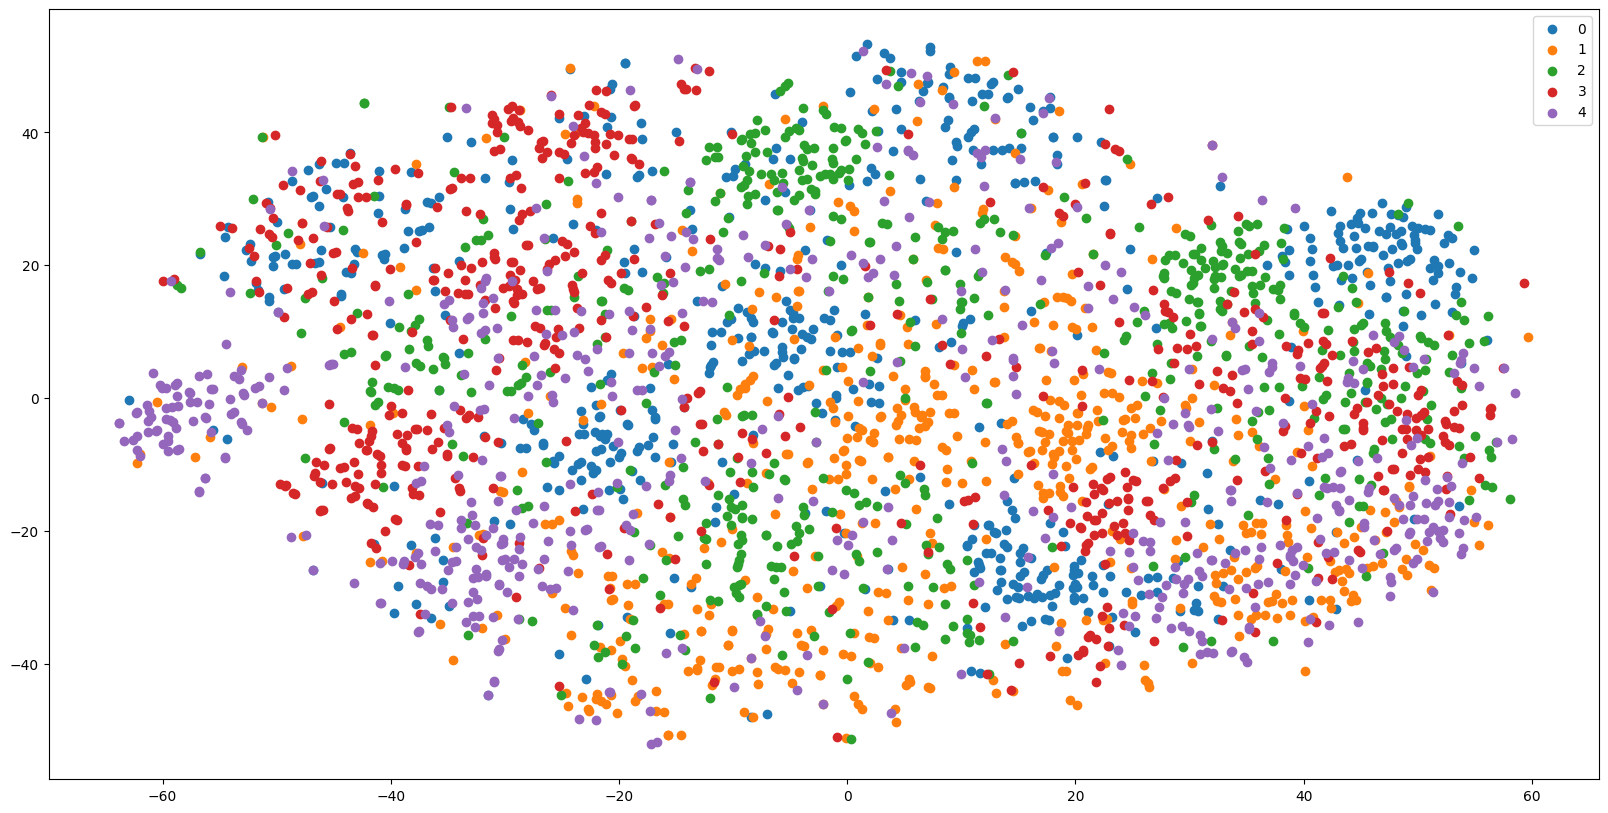

In [14]:
plt.figure(figsize=(20,10))

for y_label in np.unique(Y):
    plt.scatter(X_embedded[Y == y_label, 0], X_embedded[Y == y_label, 1], label=y_label)

plt.legend();

In [15]:
X_embedded.shape

(3000, 2)

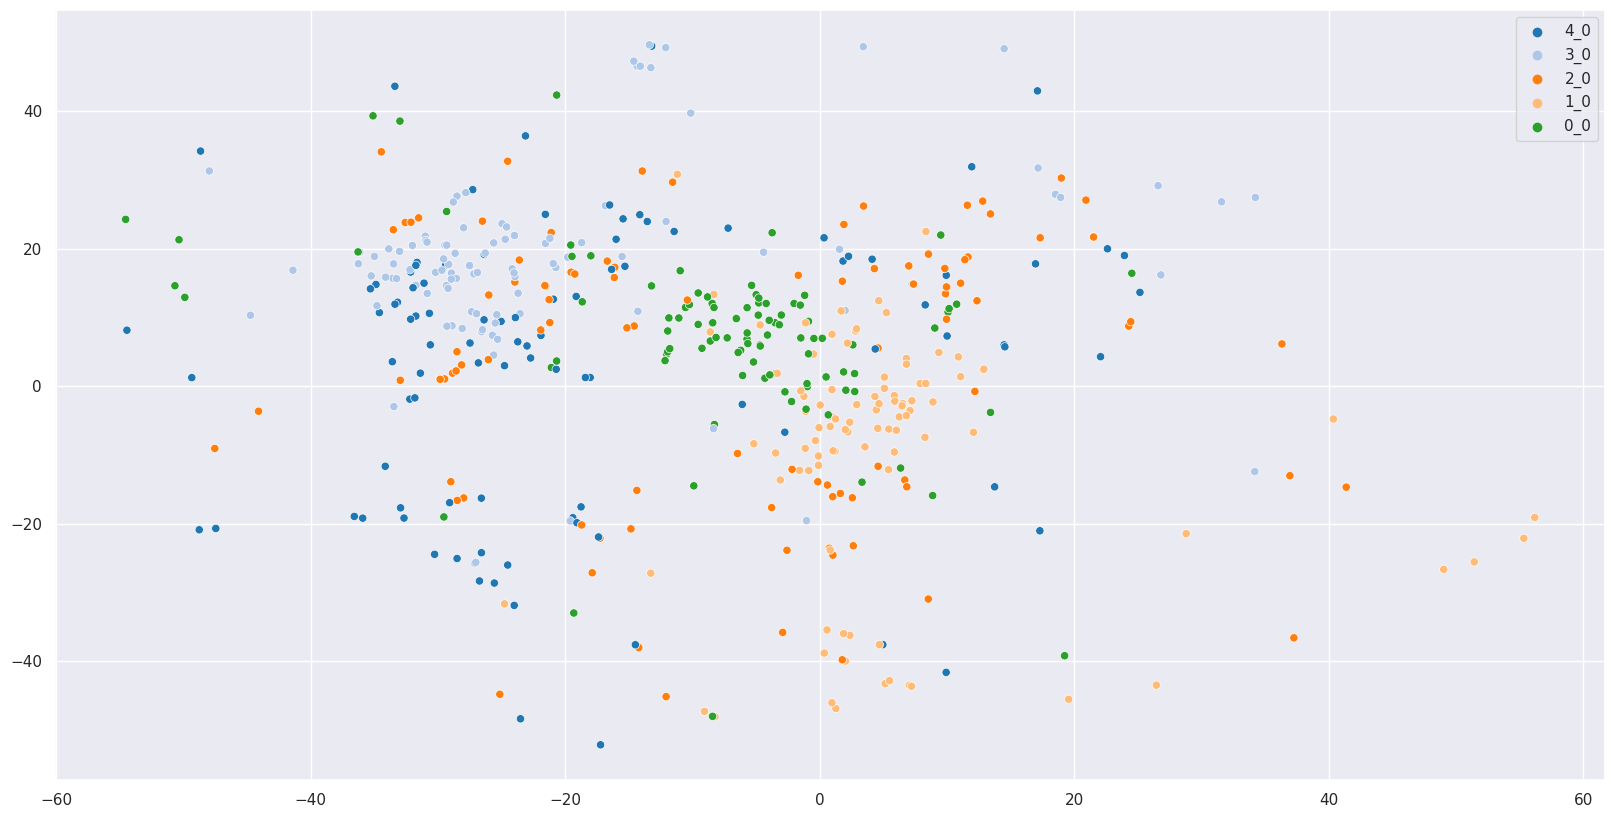

In [16]:
# create an array same size as y and y_task where each element is {y}_{y_task} string
y_task_str = np.array([str(Y[i]) + "_" + str(y_task[i]) for i in range(len(Y))]) # class_task
# plot X_embedded with color corresponding to y_task_str
import seaborn as sns
# different sns color palette
# bigger plot size
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette("tab20")

task = 0
X_t = X_embedded[y_task == task]
y_t = y_task_str[y_task == task]
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue=y_t);
# sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_task_str);